In [ ]:
!unzip d2d-data.zip

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import random
import math
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import special as sp
from scipy.stats import gaussian_kde
from scipy.io import loadmat
from sklearn.neighbors import KernelDensity
from scipy import special as sp
import warnings
warnings.filterwarnings('ignore')

# Data Load

## D2D data

In [4]:
def D2D_data_linear():   
  """
  Data normalised with respect to their global means
  """
  UE1head_UE2head_LOS_indoor = pd.read_csv('/content/Datasets/D2D_UE1head_UE2head_LOS_Indoor_1khz_mv.txt', delimiter = "\t", header=None)
  UE1head_UE2head_NLOS_indoor = pd.read_csv('/content/Datasets/D2D_UE1head_UE2head_NLOS_indoor_1khz_mv.txt', delimiter = "\t", header=None)
  UE1head_UE2head_NLOS_outdoor = pd.read_csv('/content/Datasets/D2D_UE1head_UE2head_NLOS_outdoor_1khz_mv.txt', delimiter = "\t", header=None)
    
  return UE1head_UE2head_LOS_indoor.T[500:10000].reset_index(drop=True), UE1head_UE2head_NLOS_indoor.T[500:10000].reset_index(drop=True),\
   UE1head_UE2head_NLOS_outdoor.T[500:10000].reset_index(drop=True)

def D2D_SSF_data_linear():   
  """
  Data normalised with respect to their local means (ssf)
  """
  UE1head_UE2pocket_LOS = pd.read_csv('/content/Datasets/d2d_ssf_UE1head_UE2pocket_LOS_mv.txt', delimiter = "\t", header=None, )
  UE1head_UE2pocket_NLOS = pd.read_csv('/content/Datasets/d2d_ssf_UE1head_UE2pocket_NLOS_mv.txt', delimiter = "\t", header=None)
  UE1text_UE2head_LOS = pd.read_csv('/content/Datasets/d2d_ssf_UE1texting_UE2head_LOS_mv.txt', delimiter = "\t", header=None)

  return UE1head_UE2pocket_LOS.T, UE1head_UE2pocket_NLOS.T, UE1text_UE2head_LOS.T


##########################
#### LOAD GLOBAL MEAN ####
##########################
# SSF_pathAB_dB = pd.DataFrame()
UE1head_UE2head_LOS_indoor, \
UE1head_UE2head_NLOS_indoor, \
UE1head_UE2head_NLOS_outdoor = D2D_data_linear()

##########################
####  LOAD LOCAL MEAN ####
##########################
# SSF_pathAB_linear = pd.DataFrame()
UE1head_UE2pocket_LOS, \
UE1head_UE2pocket_NLOS, \
UE1text_UE2head_LOS = D2D_SSF_data_linear()


##########################
#### PRINT STATISTICS ####
##########################
print('Normalised wrt Global Mean')
print('UE1: Head | UE2: Head (LOS - Indoor) Statistics:')
display(UE1head_UE2head_LOS_indoor.describe())
print('UE1: Head | UE2: Head (NLOS - Indoor) Statistics:')
display(UE1head_UE2head_NLOS_indoor.describe())
print('UE1: Head | UE2: Head (NLOS - Outdoor) Statistics:')
display(UE1head_UE2head_NLOS_outdoor.describe())

print('Normalised wrt Local Mean')
print('UE1: Head | UE2: Pocket (LOS) Statistics:')
display(UE1head_UE2pocket_LOS.describe())
print('UE1: Head | UE2: Pocket (NLOS) Statistics:')
display(UE1head_UE2pocket_NLOS.describe())
print('UE1: Texting | UE2: Head (LOS) Statistics:')
display(UE1text_UE2head_LOS.describe())


Normalised wrt Global Mean
UE1: Head | UE2: Head (LOS - Indoor) Statistics:


,0
count,9500.000000
mean,0.921931
std,0.601470
min,0.017674
25%,0.508960
50%,0.773810
75%,1.185725
max,4.710200


UE1: Head | UE2: Head (NLOS - Indoor) Statistics:


,0
count,9500.000000
mean,0.995891
std,0.648062
min,0.012973
25%,0.498070
50%,0.875770
75%,1.381550
max,4.511200


UE1: Head | UE2: Head (NLOS - Outdoor) Statistics:


,0
count,9500.000000
mean,1.063997
std,0.682374
min,0.086185
25%,0.612620
50%,0.915005
75%,1.352000
max,4.497600


Normalised wrt Local Mean
UE1: Head | UE2: Pocket (LOS) Statistics:


,0
count,352.000000
mean,0.984655
std,0.325573
min,0.179790
25%,0.753408
50%,0.987740
75%,1.197825
max,2.244300


UE1: Head | UE2: Pocket (NLOS) Statistics:


,0
count,359.000000
mean,0.963644
std,0.263986
min,0.166430
25%,0.789900
50%,0.954080
75%,1.145800
max,1.933800


UE1: Texting | UE2: Head (LOS) Statistics:


,0
count,329.000000
mean,0.989625
std,0.269059
min,0.182660
25%,0.825610
50%,0.981770
75%,1.162800
max,1.812700


# Auxiliary Methods

In [29]:
def tic():
    #Homemade version of matlab tic and toc functions
    import time
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()

def toc():
    import time
    if 'startTime_for_tictoc' in globals():
        print("Elapsed time is " + str(time.time() - startTime_for_tictoc) + " seconds.")
    else:
        print("Toc: start time not set") 

def shadowedKappaMuPDF(r, kappa, mu, omega, md):
  '''
  shadowed kappa-mu pdf (type 1).
  '''
  A = 2 * r**((2*mu) -1) / omega**(mu)
  B = (mu**mu * md**md * (1+kappa)**mu) / (sp.gamma(mu) * ((mu*kappa)+md)**md)
  C = np.exp((- mu * (1+kappa) * r**2) / omega)
  D = (mu**2) * kappa * (1+kappa) * (r**2)
  E = ((mu*kappa)+md) * omega
  F = sp.hyp1f1(md, mu, D / E)

  pdf = A * B * C * F
  return pdf

def shadowedKappaMuPDF_t2(r, kappa, mu, r_hat, ms):
  '''
  shadowed kappa-mu pdf (type 2).
  '''
  A = 2 * ( ( ms - 1 ) ** ( ms ) ) * ( r ** ( ( 2 * mu ) - 1 ) )  * ( r_hat ** ( 2 * ms ) ) * ( ( 1 + kappa ) ** mu) * ( mu ** mu )
  B = sp.beta(ms, mu ) * ( ( ( (r ** 2) * (1 + kappa) * mu ) + ( ( r_hat ** 2 ) * ( ms - 1 + (kappa * mu) ) ) ) ** ( mu + ms ) )
  C = (ms+mu)/2
  D = (1+ms+mu)/2
  E = 4 * (mu**2) * kappa * (1 + kappa) * (r**2) * (r_hat**2)
  F = ( ( (r**2) * (1 + kappa) * mu ) + ( ( r_hat**2 ) * ( ms - 1 + (kappa * mu) ) ) )**2
  G = sp.hyp2f1( C, D, mu, E / F )

  pdf = (A/B)*G
  return pdf

def shadowedKappaMuPDF_t3(r, kappa, mu, r_hat, mt):
  '''
  shadowed kappa-mu pdf (type 3).
  '''
  A = 2 * ( ( 1 + kappa ) ** mu) * ( mu ** mu ) * math.exp( -kappa * mu ) * ( ( (mt - 1) * ( r_hat ** 2 ) )**( mt ) ) * ( r ** ( ( 2 * mu ) - 1 ) )
  B = sp.beta(mt, mu) * ( ( ( (r ** 2) * (1 + kappa) * mu ) + ( ( r_hat ** 2 ) * ( mt - 1 ) ) )**( mu + mt ) )
  C = (mt+mu)
  D = ( mu ** 2 ) * kappa * ( 1 + kappa ) * ( r**2)
  E = ( ( (r**2) * (1 + kappa) * mu ) + ( ( r_hat**2 ) * ( mt - 1 ) ) )
  F = sp.hyp1f1(C, mu, D/E )

  pdf = (A/B)*F
  return pdf

def kldiv(pVec1, pVec2):
  '''
  Kullback-Leibler divergence.
  '''
  KL = np.sum(pVec1*(np.log2(pVec1)-np.log2(pVec2)))
  return KL

def RAD(kldiv1, kldiv2):
  '''
  Resistor-Average Distance.
  '''
  RAD = 1/(1/kldiv1+1/kldiv2)
  return RAD

def getDensityEstimationSamples(linear_data, nExtractedSamples, case):
  '''
  Extracted KDE uniformly spaced samples from the data.
  '''
  Xdata = np.linspace(linear_data.min(), linear_data.max(), nExtractedSamples).reshape(-1, 1)
  kde = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(linear_data.values.reshape(-1, 1))
  
  logkde = kde.score_samples(Xdata)
  Ydata = np.exp(logkde).reshape(-1,1)
  plt.figure(figsize=(10,7))
  plt.scatter(20*np.log10(Xdata), Ydata, c='magenta')
  plt.title(f'{case}')
  plt.ylabel('Density')
  plt.xlabel('Composite Fading (dB)')
  plt.grid()
  plt.show()
  return Xdata, Ydata

def printSummary(case, fitnessType):
  print('='*30+'\n'+'Genetic Algorithm Fitting\nFitness Type: {}\nCase: {}\n'.format(fitnessType, case))

def computeAIC(data, n, K, nls_skut1, nls_skut2, nls_skut3, ga_skut1_mse, ga_skut1_rad,\
               ga_skut2_mse, ga_skut2_rad, ga_skut3_mse, ga_skut3_rad):

    # AIC NLS - SHADOWED KAPPA MU T1
    sum = np.sum(np.log(shadowedKappaMuPDF(data, nls_skut1[0], nls_skut1[1], nls_skut1[2], nls_skut1[3]).astype(float)))
    AIC_nls_shadowed_kappa_mu_t1 = -2*sum + 2*K + (2*K*(K+1))/(n-K-1)

    # AIC GENETIC ALGORITHM SHADOWED KAPPA MU T1 - FITNESS: MSE
    sum = np.sum(np.log(shadowedKappaMuPDF(data, ga_skut1_mse[0], ga_skut1_mse[1], ga_skut1_mse[2], ga_skut1_mse[3])))
    AIC_ga_shadowed_kappa_mu_t1 = -2*sum + 2*K + (2*K*(K+1))/(n-K-1)

    # AIC GENETIC ALGORITHM SHADOWED KAPPA MU T1 - FITNESS: RAD
    sum = np.sum(np.log(shadowedKappaMuPDF(data, ga_skut1_rad[0], ga_skut1_rad[1], ga_skut1_rad[2], ga_skut1_rad[3])))
    AIC_ga_shadowed_kappa_mu_t1_rad = -2*sum + 2*K + (2*K*(K+1))/(n-K-1)

    # AIC NLS - SHADOWED KAPPA MU T2
    sum = np.sum(np.log(shadowedKappaMuPDF_t2(data, nls_skut2[0], nls_skut2[1], nls_skut2[2], nls_skut2[3]).astype(float)))
    AIC_nls_shadowed_kappa_mu_t2 = -2*sum + 2*K + (2*K*(K+1))/(n-K-1)

    # AIC GENETIC ALGORITHM SHADOWED KAPPA MU T2 - FITNESS: MSE
    sum = np.sum(np.log(shadowedKappaMuPDF_t2(data, ga_skut2_mse[0], ga_skut2_mse[1], ga_skut2_mse[2], ga_skut2_mse[3])))
    AIC_ga_shadowed_kappa_mu_t2 = -2*sum + 2*K + (2*K*(K+1))/(n-K-1)

    # AIC GENETIC ALGORITHM SHADOWED KAPPA MU T2 - FITNESS: RAD
    sum = np.sum(np.log(shadowedKappaMuPDF_t2(data, ga_skut2_rad[0], ga_skut2_rad[1], ga_skut2_rad[2], ga_skut2_rad[3])))
    AIC_ga_shadowed_kappa_mu_t2_rad = -2*sum + 2*K + (2*K*(K+1))/(n-K-1)

    # AIC NLS - SHADOWED KAPPA MU T3
    sum = np.sum(np.log(shadowedKappaMuPDF_t3(data, nls_skut3[0], nls_skut3[1], nls_skut3[2], nls_skut3[3]).astype(float)))
    AIC_nls_shadowed_kappa_mu_t3 = -2*sum + 2*K + (2*K*(K+1))/(n-K-1)

    # AIC GENETIC ALGORITHM SHADOWED KAPPA MU T3 - FITNESS: MSE
    sum = np.sum(np.log(shadowedKappaMuPDF_t3(data, ga_skut3_mse[0], ga_skut3_mse[1], ga_skut3_mse[2], ga_skut3_mse[3])))
    AIC_ga_shadowed_kappa_mu_t3 = -2*sum + 2*K + (2*K*(K+1))/(n-K-1)

    # AIC GENETIC ALGORITHM SHADOWED KAPPA MU T3 - FITNESS: RAD
    sum = np.sum(np.log(shadowedKappaMuPDF_t3(data, ga_skut3_rad[0], ga_skut3_rad[1], ga_skut3_rad[2], ga_skut3_rad[3])))
    AIC_ga_shadowed_kappa_mu_t3_rad = -2*sum + 2*K + (2*K*(K+1))/(n-K-1)

    rads = {'Methods':['NLS - Shad. KappaMu T1', 'GA - Shad. KappaMu T1 (Fitness = MSE)',\
                       'GA - Shad. KappaMu T1 (Fitness = RAD)',\
                       'NLS - Shad. KappaMu T2', 'GA - Shad. KappaMu T2 (Fitness = MSE)',\
                       'GA - Shad. KappaMu T2 (Fitness = RAD)',\
                       'NLS - Shad. KappaMu T3', 'GA - Shad. KappaMu T3 (Fitness = MSE)',\
                       'GA - Shad. KappaMu T3 (Fitness = RAD)'],
        'Akaike Information Criteria':[AIC_nls_shadowed_kappa_mu_t1[0], AIC_ga_shadowed_kappa_mu_t1[0], AIC_ga_shadowed_kappa_mu_t1_rad[0],\
                                       AIC_nls_shadowed_kappa_mu_t2[0], AIC_ga_shadowed_kappa_mu_t2[0], AIC_ga_shadowed_kappa_mu_t2_rad[0],\
                                       AIC_nls_shadowed_kappa_mu_t3[0], AIC_ga_shadowed_kappa_mu_t3[0], AIC_ga_shadowed_kappa_mu_t3_rad[0]]}
    
    df = pd.DataFrame(rads)
    display(df.sort_values(by='Akaike Information Criteria').reset_index(drop=True))
    
    return df

def plotResults(Xdata, Ydata, sku_t1_pdf, sku_t2_pdf, sku_t3_pdf, \
                ga_sku_t1_mse, ga_sku_t1_rad, \
                ga_sku_t2_mse, ga_sku_t2_rad, \
                ga_sku_t3_mse, ga_sku_t3_rad, case):
    plt.figure(figsize=((10,7)))
    plt.scatter(20*np.log10(Xdata), Ydata, c='black')
    plt.plot(20*np.log10(Xdata), sku_t1_pdf, label=r'Shad. $\kappa$-$\mu$ (Type 1) NLS')
    plt.plot(20*np.log10(Xdata), sku_t2_pdf, label=r'Shad. $\kappa$-$\mu$ (Type 2) NLS')
    plt.plot(20*np.log10(Xdata), sku_t3_pdf, label=r'Shad. $\kappa$-$\mu$ (Type 2) NLS')
    plt.plot(20*np.log10(Xdata), shadowedKappaMuPDF(Xdata, ga_sku_t1_mse[0], ga_sku_t1_mse[1], ga_sku_t1_mse[2], ga_sku_t1_mse[3]), label='GA: Shad. $\kappa$-$\mu$ (Type 1) (MSE)')
    plt.plot(20*np.log10(Xdata), shadowedKappaMuPDF_t2(Xdata, ga_sku_t2_mse[0], ga_sku_t2_mse[1], ga_sku_t2_mse[2], ga_sku_t2_mse[3]), label='GA: Shad. $\kappa$-$\mu$ (Type 2) (MSE)')
    plt.plot(20*np.log10(Xdata), shadowedKappaMuPDF_t3(Xdata, ga_sku_t3_mse[0], ga_sku_t3_mse[1], ga_sku_t3_mse[2], ga_sku_t3_mse[3]), label='GA: Shad. $\kappa$-$\mu$ (Type 3) (MSE)')
    plt.plot(20*np.log10(Xdata), shadowedKappaMuPDF(Xdata, ga_sku_t1_rad[0], ga_sku_t1_rad[1], ga_sku_t1_rad[2], ga_sku_t1_rad[3]), label='GA: Shad. $\kappa$-$\mu$ (Type 1) (RAD)')
    plt.plot(20*np.log10(Xdata), shadowedKappaMuPDF_t2(Xdata, ga_sku_t2_rad[0], ga_sku_t2_rad[1], ga_sku_t2_rad[2], ga_sku_t2_rad[3]), label='GA: Shad. $\kappa$-$\mu$ (Type 2) (RAD)')
    plt.plot(20*np.log10(Xdata), shadowedKappaMuPDF_t3(Xdata, ga_sku_t3_rad[0], ga_sku_t3_rad[1], ga_sku_t3_rad[2], ga_sku_t3_rad[3]), label='GA: Shad. $\kappa$-$\mu$ (Type 3) (RAD)')
    plt.title(f'{case}')
    plt.legend()
    plt.grid(True)
    plt.xlabel(r'Composite Fading (dB)')
    plt.ylabel('Density')
    plt.savefig('(dB) sku_t1_t2_t3_case_{}.pdf'.format(case, dpi=150))
    plt.show()
    
    plt.figure(figsize=((10,7)))
    plt.scatter(Xdata, Ydata, c='black')
    plt.plot(Xdata, sku_t1_pdf, label=r'Shad. $\kappa$-$\mu$ (Type 1) NLS')
    plt.plot(Xdata, sku_t2_pdf, label=r'Shad. $\kappa$-$\mu$ (Type 2) NLS')
    plt.plot(Xdata, sku_t3_pdf, label=r'Shad. $\kappa$-$\mu$ (Type 2) NLS')
    plt.plot(Xdata, shadowedKappaMuPDF(Xdata, ga_sku_t1_mse[0], ga_sku_t1_mse[1], ga_sku_t1_mse[2], ga_sku_t1_mse[3]), label='GA: Shad. $\kappa$-$\mu$ (Type 1) (MSE)')
    plt.plot(Xdata, shadowedKappaMuPDF_t2(Xdata, ga_sku_t2_mse[0], ga_sku_t2_mse[1], ga_sku_t2_mse[2], ga_sku_t2_mse[3]), label='GA: Shad. $\kappa$-$\mu$ (Type 2) (MSE)')
    plt.plot(Xdata, shadowedKappaMuPDF_t3(Xdata, ga_sku_t3_mse[0], ga_sku_t3_mse[1], ga_sku_t3_mse[2], ga_sku_t3_mse[3]), label='GA: Shad. $\kappa$-$\mu$ (Type 3) (MSE)')
    plt.plot(Xdata, shadowedKappaMuPDF(Xdata, ga_sku_t1_rad[0], ga_sku_t1_rad[1], ga_sku_t1_rad[2], ga_sku_t1_rad[3]), label='GA: Shad. $\kappa$-$\mu$ (Type 1) (RAD)')
    plt.plot(Xdata, shadowedKappaMuPDF_t2(Xdata, ga_sku_t2_rad[0], ga_sku_t2_rad[1], ga_sku_t2_rad[2], ga_sku_t2_rad[3]), label='GA: Shad. $\kappa$-$\mu$ (Type 2) (RAD)')
    plt.plot(Xdata, shadowedKappaMuPDF_t3(Xdata, ga_sku_t3_rad[0], ga_sku_t3_rad[1], ga_sku_t3_rad[2], ga_sku_t3_rad[3]), label='GA: Shad. $\kappa$-$\mu$ (Type 3) (RAD)')
    plt.title(f'{case}')
    plt.legend()
    plt.grid(True)
    plt.xlabel(r'Composite Fading (linear)')
    plt.ylabel('Density')
    plt.savefig('(linear) sku_t1_t2_t3_case_{}.pdf'.format(case, dpi=150))
    plt.show()

In [100]:
def fitness_skut1(X, Y, fitnessType, kappa, mu, omega, md):
  '''
  Fitness function (MSE/RAD) to determine how good a given solution is.
  (Shadowed Kappa Mu Type 1)
  '''
  if fitnessType == 'MSE':
    y_pred = shadowedKappaMuPDF(X, kappa, mu, omega, md)
    n = len(Y)
    sum = []
    for val in (Y-y_pred):
      sum.append(val**2)
    sum = np.sum(sum)
    cost = 1/n * sum
    return 1/cost
  elif fitnessType == 'RAD':
    pVec1 = Y/np.sum(Y)
    pVec2 = shadowedKappaMuPDF(X, kappa, mu, omega, md)/np.sum(shadowedKappaMuPDF(X, kappa, mu, omega, md))
    KLD_1 = kldiv(pVec1, pVec2)
    KLD_2 = kldiv(pVec2, pVec1)
    cost = RAD(KLD_1, KLD_2)
    return 1/cost


def geneticAlgorithm_skut1(X, Y, threshold, firstFlag=True):
  '''
  Genetic Algorithm incorporating Shadowed Kappa Mu Type 1 in the Fitness Function
  It fits kappa, mu, omega, md
  '''
  if firstFlag:
        tic()
  solutions = []
  bestParams = []
  bestCriteria = 0
  bestGen = 0


  # Generate solutions (chromossomes)
  for s in range(nPopulation):
    solutions.append((random.uniform(0.01, 11), # kappa
                        random.uniform(0.01, 3.0), # mu
                        random.uniform(0.01, 3.0), # r_hat^2
                        random.uniform(0.01, 20.0))) # md

  # Evolutionary Loop
  for i in range(nMaxGen):
    rankedSolutions = []
    for s in solutions:
      rankedSolutions.append( (fitness_skut1(X, Y, fitnessType, s[0],s[1],s[2],s[3]), s) )
    rankedSolutions.sort()
    rankedSolutions.reverse()
    
    # print(f'=== Generation: {i} === ')
    # print(f'Fitness: {rankedSolutions[0][0]}')
    # print('Best individual:')
    # print(f'Kappa: {rankedSolutions[0][1][0]}')
    # print(f'Mu: {rankedSolutions[0][1][1]}')
    # print(f'Omega: {rankedSolutions[0][1][2]}')
    # print(f'Md: {rankedSolutions[0][1][3]}\n')

    # Keeping track the best params and generation:
    if rankedSolutions[0][0] > bestCriteria:
      bestCriteria = rankedSolutions[0][0]
      bestGen = i
      bestParams = rankedSolutions[0][1]

    # Check if it is good enough according to a satisfactory threshold:
    if bestCriteria > threshold:
      print('Satisfactory Threshold reached!')  
      toc()
      print('\nBest Fitness: {}\nBest Gen: {}'.format(bestCriteria, bestGen))
      print('Kappa: {}\nMu: {}\nOmega: {}\nMd: {}'.format(bestParams[0],bestParams[1],bestParams[2],bestParams[3]))
      return bestParams[0],bestParams[1],bestParams[2],bestParams[3]
    
    # Combine the best solutions and make a new solution of those combined solutions
    bestSolutions = rankedSolutions[:100]
    elements_kappa = []
    elements_mu = []
    elements_omega = [] 
    elements_md = [] 
    for s in bestSolutions:
      elements_kappa.append(s[1][0])
      elements_mu.append(s[1][1])
      elements_omega.append(s[1][2])
      elements_md.append(s[1][3])

    newGen = []
    for _ in range(nPopulation):
      e1 = random.choice(elements_kappa) * random.uniform(0.975,1.025) # Mutation of 5%
      e2 = random.choice(elements_mu) * random.uniform(0.975,1.025) # Mutation of 5%
      e3 = random.choice(elements_omega) * random.uniform(0.975,1.025) # Mutation of 5%
      e4 = random.choice(elements_md) * random.uniform(0.975,1.025) # Mutation of 5%
      
      newGen.append((e1,e2,e3,e4))

    solutions = newGen
    
    if i == nMaxGen-1:
      print('Max number of generations reached! (Possible bad initialization)\nRestarting...\n')
      b0, b1, b2, b3 = geneticAlgorithm_skut1(X, Y, threshold, False)
        
      return b0, b1, b2, b3

In [138]:
def fitness_skut2(X, Y, fitnessType, kappa, mu, omega, ms):
  '''
  Fitness function (MSE/RAD) to determine how good a given solution is.
  (Shadowed Kappa Mu Type 2)
  '''
  if fitnessType == 'MSE':
    y_pred = shadowedKappaMuPDF_t2(X, kappa, mu, omega, ms).astype(float)
    n = len(Y)
    sum = []
    for val in (Y-y_pred):
      sum.append(val**2)
    sum = np.sum(sum)
    cost = 1/n * sum
    return 1/cost
  elif fitnessType == 'RAD':
    pVec1 = Y/np.sum(Y)
    pVec2 = shadowedKappaMuPDF_t2(X, kappa, mu, omega, ms).astype(float)/np.sum(shadowedKappaMuPDF_t2(X, kappa, mu, omega, ms).astype(float))
    KLD_1 = kldiv(pVec1, pVec2)
    KLD_2 = kldiv(pVec2, pVec1)
    cost = RAD(KLD_1, KLD_2)
    return 1/cost


def geneticAlgorithm_skut2(X, Y, threshold, firstFlag=True):
  '''
  Genetic Algorithm incorporating Shadowed Kappa Mu Type 2 in the Fitness Function
  It fits kappa, mu, omega, ms
  '''
  if firstFlag:
        tic()
  solutions = []
  bestParams = []
  bestCriteria = 0
  bestGen = 0


  # Generate solutions (chromossomes)
  for s in range(nPopulation):
    solutions.append((random.uniform(0.001, 70), # kappa
                        random.uniform(0.01, 3.0), # mu
                        random.uniform(0.01, 2.5), # r_hat
                        random.uniform(0.01, 100))) # ms

  # Evolutionary Loop
  for i in range(nMaxGen):
    rankedSolutions = []
    for s in solutions:
      if s[3] > 110: # Forcing Ms parameter to not get too high (avoiding overflow)
        s = list(s)
        s[3] = 105
        s = tuple(s)
      rankedSolutions.append( (fitness_skut2(X, Y, fitnessType, s[0],s[1],s[2],s[3]), s) )
    rankedSolutions.sort()
    rankedSolutions.reverse()
    
    # print(f'=== Generation: {i} === ')
    # print(f'Fitness: {rankedSolutions[0][0]}')
    # print('Best individual:')
    # print(f'Kappa: {rankedSolutions[0][1][0]}')
    # print(f'Mu: {rankedSolutions[0][1][1]}')
    # print(f'Omega: {rankedSolutions[0][1][2]}')
    # print(f'Ms: {rankedSolutions[0][1][3]}\n')

    # Keeping track the best params and generation:
    if rankedSolutions[0][0] > bestCriteria:
      bestCriteria = rankedSolutions[0][0]
      bestGen = i
      bestParams = rankedSolutions[0][1]

    # Check if it is good enough according to a satisfactory threshold:
    if bestCriteria > threshold:
      print('Satisfactory Threshold reached!')  
      toc()
      print('\nBest Fitness: {}\nBest Gen: {}'.format(bestCriteria, bestGen))
      print('Kappa: {}\nMu: {}\nR_hat: {}\nMs: {}'.format(bestParams[0],bestParams[1],bestParams[2],bestParams[3]))
      return bestParams[0],bestParams[1],bestParams[2],bestParams[3]
    
    # Combine the best solutions and make a new solution of those combined solutions
    bestSolutions = rankedSolutions[:100]
    elements_kappa = []
    elements_mu = []
    elements_r_hat = [] 
    elements_ms = [] 
    for s in bestSolutions:
      elements_kappa.append(s[1][0])
      elements_mu.append(s[1][1])
      elements_r_hat.append(s[1][2])
      elements_ms.append(s[1][3])

    newGen = []
    for _ in range(nPopulation):
      e1 = random.choice(elements_kappa) * random.uniform(0.975,1.025) # Mutation of 5%
      e2 = random.choice(elements_mu) * random.uniform(0.975,1.025) # Mutation of 5%
      e3 = random.choice(elements_r_hat) * random.uniform(0.975,1.025) # Mutation of 5%
      e4 = random.choice(elements_ms) * random.uniform(0.975,1.025) # Mutation of 5%
      
      newGen.append((e1,e2,e3,e4))

    solutions = newGen
    
    if i == nMaxGen-1:
      print('Max number of generations reached! (Possible bad initialization)\nRestarting...\n')
      b0, b1, b2, b3 = geneticAlgorithm_skut2(X, Y, threshold, False)
        
      return b0, b1, b2, b3

In [15]:
def fitness_skut3(X, Y, fitnessType, kappa, mu, omega, mt):
  '''
  Fitness function (MSE/RAD) to determine how good a given solution is.
  (Shadowed Kappa Mu Type 3)
  '''
  if fitnessType == 'MSE':
    y_pred = shadowedKappaMuPDF_t3(X, kappa, mu, omega, mt)
    n = len(Y)
    sum = []
    for val in (Y-y_pred):
      sum.append(val**2)
    sum = np.sum(sum)
    cost = 1/n * sum
    return 1/cost
  elif fitnessType == 'RAD':
    pVec1 = Y/np.sum(Y)
    pVec2 = shadowedKappaMuPDF_t3(X, kappa, mu, omega, mt)/np.sum(shadowedKappaMuPDF_t3(X, kappa, mu, omega, mt))
    KLD_1 = kldiv(pVec1, pVec2)
    KLD_2 = kldiv(pVec2, pVec1)
    cost = RAD(KLD_1, KLD_2)
    return 1/cost


def geneticAlgorithm_skut3(X, Y, threshold, firstFlag=True):
  '''
  Genetic Algorithm incorporating Shadowed Kappa Mu Type 3 in the Fitness Function
  It fits kappa, mu, omega, mt
  '''
  if firstFlag:
        tic()
  solutions = []
  bestParams = []
  bestCriteria = 0
  bestGen = 0


  # Generate solutions (chromossomes)
  for s in range(nPopulation):
    solutions.append((random.uniform(0.001, 70), # kappa
                        random.uniform(0.01, 3.0), # mu
                        random.uniform(0.01, 2.5), # r_hat
                        random.uniform(1.001, 100))) # mt

  # Evolutionary Loop
  for i in range(nMaxGen):
    rankedSolutions = []
    for s in solutions:
      rankedSolutions.append( (fitness_skut3(X, Y, fitnessType, s[0],s[1],s[2],s[3]), s) )
    rankedSolutions.sort()
    rankedSolutions.reverse()
    
    # print(f'=== Generation: {i} === ')
    # print(f'Fitness: {rankedSolutions[0][0]}')
    # print('Best individual:')
    # print(f'Kappa: {rankedSolutions[0][1][0]}')
    # print(f'Mu: {rankedSolutions[0][1][1]}')
    # print(f'Omega: {rankedSolutions[0][1][2]}')
    # print(f'Mt: {rankedSolutions[0][1][3]}\n')

    # Keeping track the best paramt and generation:
    if rankedSolutions[0][0] > bestCriteria:
      bestCriteria = rankedSolutions[0][0]
      bestGen = i
      bestParams = rankedSolutions[0][1]

    # Check if it is good enough according to a satisfactory threshold:
    if bestCriteria > threshold:
      print('Satisfactory Threshold reached!')  
      toc()
      print('\nBest Fitness: {}\nBest Gen: {}'.format(bestCriteria, bestGen))
      print('Kappa: {}\nMu: {}\nR_hat: {}\nMt: {}'.format(bestParams[0],bestParams[1],bestParams[2],bestParams[3]))
      return bestParams[0],bestParams[1],bestParams[2],bestParams[3]
    
    # Combine the best solutions and make a new solution of those combined solutions
    bestSolutions = rankedSolutions[:100]
    elements_kappa = []
    elements_mu = []
    elements_r_hat = [] 
    elements_mt = [] 
    for s in bestSolutions:
      elements_kappa.append(s[1][0])
      elements_mu.append(s[1][1])
      elements_r_hat.append(s[1][2])
      elements_mt.append(s[1][3])

    newGen = []
    for _ in range(nPopulation):
      e1 = random.choice(elements_kappa) * random.uniform(0.975,1.025) # Mutation of 5%
      e2 = random.choice(elements_mu) * random.uniform(0.975,1.025) # Mutation of 5%
      e3 = random.choice(elements_r_hat) * random.uniform(0.975,1.025) # Mutation of 5%
      e4 = random.choice(elements_mt) * random.uniform(0.975,1.025) # Mutation of 5%
      
      newGen.append((e1,e2,e3,e4))

    solutions = newGen
    
    if i == nMaxGen-1:
      print('Max number of generations reached! (Possible bad initialization)\nRestarting...\n')
      b0, b1, b2, b3 = geneticAlgorithm_skut3(X, Y, threshold, False)
        
      return b0, b1, b2, b3

# Composite Fading Fitting (PARAMETERS)

In [101]:
### PARAMETERS
nMaxGen = 200
nPopulation = 1000
nExtractedSamples = 81

## Shadowed $\kappa$-$\mu$ Type 2 and Type 3



### D2D UE1 head - UE2 head LOS (indoor) [Case 1]

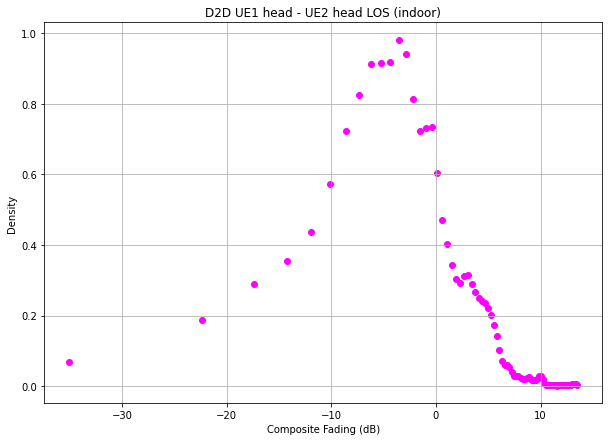

In [102]:
case = 'D2D UE1 head - UE2 head LOS (indoor)'
estParameters_sku_t1_t2_t3_case1 = pd.DataFrame()
Xdata, Ydata = getDensityEstimationSamples(UE1head_UE2head_LOS_indoor.dropna(), nExtractedSamples, case)

In [165]:
print('='*30+' SHADOWED KAPPA-MU T1 '+'='*30)
fitnessType = 'MSE'
printSummary(case, fitnessType)
sku_t1_kappa_mse, sku_t1_mu_mse, sku_t1_r_hat_mse, sku_t1_mt_mse = geneticAlgorithm_skut1(Xdata, Ydata, 686) #686

fitnessType = 'RAD'
printSummary(case, fitnessType)
sku_t1_kappa_rad, sku_t1_mu_rad, sku_t1_r_hat_rad, sku_t1_mt_rad = geneticAlgorithm_skut1(Xdata, Ydata, 79.6)

print('='*30+' SHADOWED KAPPA-MU T2 '+'='*30)
fitnessType = 'MSE'
printSummary(case, fitnessType)
sku_t2_kappa_mse, sku_t2_mu_mse, sku_t2_r_hat_mse, sku_t2_mt_mse = geneticAlgorithm_skut2(Xdata, Ydata, 600)

fitnessType = 'RAD'
printSummary(case, fitnessType)
sku_t2_kappa_rad, sku_t2_mu_rad, sku_t2_r_hat_rad, sku_t2_mt_rad = geneticAlgorithm_skut2(Xdata, Ydata, 86)

print('='*30+' SHADOWED KAPPA-MU T3 '+'='*30)
fitnessType = 'MSE'
printSummary(case, fitnessType)
sku_t3_kappa_mse, sku_t3_mu_mse, sku_t3_r_hat_mse, sku_t3_mt_mse = geneticAlgorithm_skut3(Xdata, Ydata, 700)

fitnessType = 'RAD'
printSummary(case, fitnessType)
sku_t3_kappa_rad, sku_t3_mu_rad, sku_t3_r_hat_rad, sku_t3_mt_rad = geneticAlgorithm_skut3(Xdata, Ydata, 94.4)

============================== SHADOWED KAPPA-MU T3 ==============================
Genetic Algorithm Fitting
Fitness Type: MSE
Case: D2D UE1 head - UE2 head LOS (indoor)

Satisfactory Threshold reached!
Elapsed time is 2.225994825363159 seconds.

Best Fitness: 758.8301951149039
Best Gen: 3
Kappa: 4.791223174941122
Mu: 0.550103116607873
R_hat: 1.2131290280720743
Mt: 1.7506289916473032
Genetic Algorithm Fitting
Fitness Type: RAD
Case: D2D UE1 head - UE2 head LOS (indoor)

Max number of generations reached! (Possible bad initialization)
Restarting...

Max number of generations reached! (Possible bad initialization)
Restarting...

Satisfactory Threshold reached!
Elapsed time is 103.48625063896179 seconds.

Best Fitness: 94.40587350870398
Best Gen: 148
Kappa: 2.212296670272514
Mu: 0.8102800583227356
R_hat: 1.1464135301603366
Mt: 1.999274571994141


#### Estimated Parameters

In [168]:
nls_sku_t1_case1 = [1.9306, 1.1943, 1.2583, 0.29176] # Shad. KappaMu T1 NLS
nls_sku_t2_case1 = [0.043478, 1.0243, 2.4566, 1.0714] # Shad. KappaMu T2 NLS
nls_sku_t3_case1 = [3.5095, 0.68893, 1.3298, 1.5201] # Shad. KappaMu T3 NLS

estParameters_sku_t1_t2_t3_case1['NLS - Shad. KappaMu T1'] = nls_sku_t1_case1
estParameters_sku_t1_t2_t3_case1['NLS - Shad. KappaMu T2'] = nls_sku_t2_case1
estParameters_sku_t1_t2_t3_case1['NLS - Shad. KappaMu T3'] = nls_sku_t3_case1

estParameters_sku_t1_t2_t3_case1['GA: Shad. KappaMu T1 - MSE'] = sku_t1_kappa_mse, sku_t1_mu_mse, sku_t1_r_hat_mse, sku_t1_mt_mse
estParameters_sku_t1_t2_t3_case1['GA: Shad. KappaMu T1 - RAD'] = sku_t1_kappa_rad, sku_t1_mu_rad, sku_t1_r_hat_rad, sku_t1_mt_rad

estParameters_sku_t1_t2_t3_case1['GA: Shad. KappaMu T2 - MSE'] = sku_t2_kappa_mse, sku_t2_mu_mse, sku_t2_r_hat_mse, sku_t2_mt_mse
estParameters_sku_t1_t2_t3_case1['GA: Shad. KappaMu T2 - RAD'] = sku_t2_kappa_rad, sku_t2_mu_rad, sku_t2_r_hat_rad, sku_t2_mt_rad

estParameters_sku_t1_t2_t3_case1['GA: Shad. KappaMu T3 - MSE'] = sku_t3_kappa_mse, sku_t3_mu_mse, sku_t3_r_hat_mse, sku_t3_mt_mse
estParameters_sku_t1_t2_t3_case1['GA: Shad. KappaMu T3 - RAD'] = sku_t3_kappa_rad, sku_t3_mu_rad, sku_t3_r_hat_rad, sku_t3_mt_rad

index = pd.Index(['kappa', 'mu', 'omega', 'md/ms/mt'])
estParameters_sku_t1_t2_t3_case1 = estParameters_sku_t1_t2_t3_case1.set_index(index)
display(estParameters_sku_t1_t2_t3_case1)

,NLS - Shad. KappaMu T1,NLS - Shad. KappaMu T2,NLS - Shad. KappaMu T3,GA: Shad. KappaMu T1 - MSE,GA: Shad. KappaMu T1 - RAD,GA: Shad. KappaMu T2 - MSE,GA: Shad. KappaMu T2 - RAD,GA: Shad. KappaMu T3 - MSE,GA: Shad. KappaMu T3 - RAD
kappa,1.93060,0.043478,3.50950,1.823886,1.409572,0.030073,0.133392,4.791223,2.212297
mu,1.19430,1.024300,0.68893,1.258998,1.064684,1.139829,1.015944,0.550103,0.810280
omega,1.25830,2.456600,1.32980,1.096838,1.178278,1.087265,1.119090,1.213129,1.146414
md/ms/mt,0.29176,1.071400,1.52010,0.329737,0.255610,2.605438,2.251571,1.750629,1.999275


#### Plots

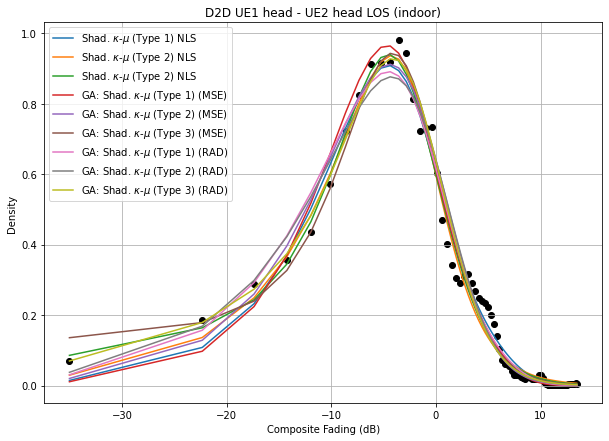

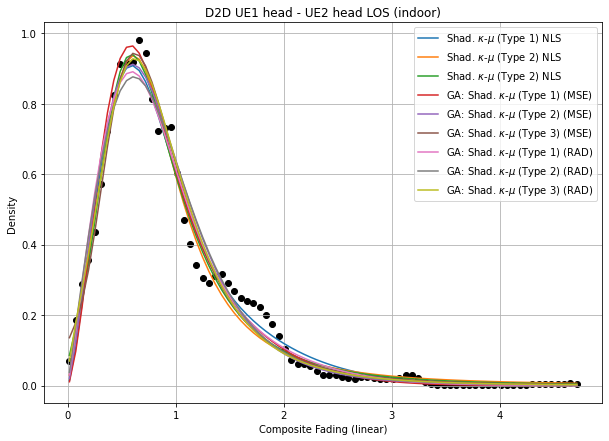

In [169]:
nls_sku_t1_case1_pdf = shadowedKappaMuPDF(Xdata, nls_sku_t1_case1[0], nls_sku_t1_case1[1], nls_sku_t1_case1[2], nls_sku_t1_case1[3]).astype(float)
nls_sku_t2_case1_pdf = shadowedKappaMuPDF_t2(Xdata, nls_sku_t2_case1[0], nls_sku_t2_case1[1], nls_sku_t2_case1[2], nls_sku_t2_case1[3]).astype(float)
nls_sku_t3_case1_pdf = shadowedKappaMuPDF_t3(Xdata, nls_sku_t3_case1[0], nls_sku_t3_case1[1], nls_sku_t3_case1[2], nls_sku_t3_case1[3]).astype(float)

plotResults(Xdata,\
     Ydata,\
     nls_sku_t1_case1_pdf,\
     nls_sku_t2_case1_pdf,\
     nls_sku_t3_case1_pdf,\
     estParameters_sku_t1_t2_t3_case1['GA: Shad. KappaMu T1 - MSE'],\
     estParameters_sku_t1_t2_t3_case1['GA: Shad. KappaMu T1 - RAD'],\
     estParameters_sku_t1_t2_t3_case1['GA: Shad. KappaMu T2 - MSE'],\
     estParameters_sku_t1_t2_t3_case1['GA: Shad. KappaMu T2 - RAD'],\
     estParameters_sku_t1_t2_t3_case1['GA: Shad. KappaMu T3 - MSE'],\
     estParameters_sku_t1_t2_t3_case1['GA: Shad. KappaMu T3 - RAD'],\
     case)

#### AIC Values

In [170]:
## AIC Analysis
data = UE1head_UE2head_LOS_indoor.dropna()
n = len(data)
K = 4

print('Case: {}'.format(case))

AIC_case1 = computeAIC(data,\
                       n,\
                       K,\
                       nls_sku_t1_case1,\
                       nls_sku_t2_case1,\
                       nls_sku_t3_case1,\
                       estParameters_sku_t1_t2_t3_case1['GA: Shad. KappaMu T1 - MSE'],\
                       estParameters_sku_t1_t2_t3_case1['GA: Shad. KappaMu T1 - RAD'],\
                       estParameters_sku_t1_t2_t3_case1['GA: Shad. KappaMu T2 - MSE'],\
                       estParameters_sku_t1_t2_t3_case1['GA: Shad. KappaMu T2 - RAD'],\
                       estParameters_sku_t1_t2_t3_case1['GA: Shad. KappaMu T3 - MSE'],\
                       estParameters_sku_t1_t2_t3_case1['GA: Shad. KappaMu T3 - RAD'])

Case: D2D UE1 head - UE2 head LOS (indoor)


,Methods,Akaike Information Criteria
0,GA - Shad. KappaMu T2 (Fitness = RAD),13788.124000
1,GA - Shad. KappaMu T2 (Fitness = MSE),13788.128531
2,GA - Shad. KappaMu T3 (Fitness = RAD),13795.594551
3,GA - Shad. KappaMu T1 (Fitness = RAD),13796.657979
4,NLS - Shad. KappaMu T1,13808.619375
5,GA - Shad. KappaMu T3 (Fitness = MSE),13877.372694
6,GA - Shad. KappaMu T1 (Fitness = MSE),13894.613162
7,NLS - Shad. KappaMu T3,13919.591232
8,NLS - Shad. KappaMu T2,14124.788543


### D2D UE1 head - UE2 head NLOS (indoor) [Case 2]

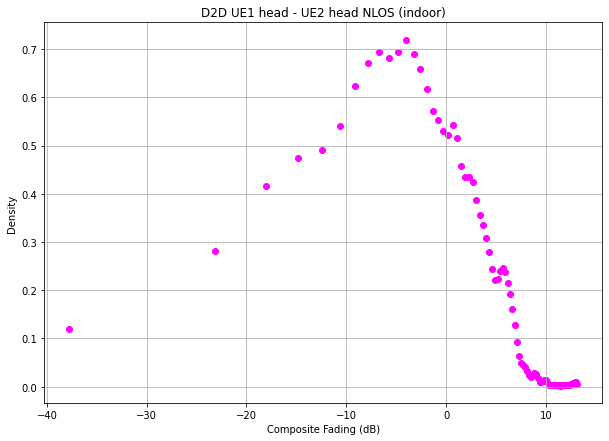

In [233]:
case = 'D2D UE1 head - UE2 head NLOS (indoor)'
estParameters_sku_t1_t2_t3_case2 = pd.DataFrame()
Xdata, Ydata = getDensityEstimationSamples(UE1head_UE2head_NLOS_indoor.dropna(), nExtractedSamples, case)

In [241]:
print('='*30+' SHADOWED KAPPA-MU T1 '+'='*30)
fitnessType = 'MSE'
printSummary(case, fitnessType)
sku_t1_kappa_mse, sku_t1_mu_mse, sku_t1_r_hat_mse, sku_t1_mt_mse = geneticAlgorithm_skut1(Xdata, Ydata, 1950) #1800 

fitnessType = 'RAD'
printSummary(case, fitnessType)
sku_t1_kappa_rad, sku_t1_mu_rad, sku_t1_r_hat_rad, sku_t1_mt_rad = geneticAlgorithm_skut1(Xdata, Ydata, 130)

print('='*30+' SHADOWED KAPPA-MU T2 '+'='*30)
fitnessType = 'MSE'
printSummary(case, fitnessType)
sku_t2_kappa_mse, sku_t2_mu_mse, sku_t2_r_hat_mse, sku_t2_mt_mse = geneticAlgorithm_skut2(Xdata, Ydata, 1500)

fitnessType = 'RAD'
printSummary(case, fitnessType)
sku_t2_kappa_rad, sku_t2_mu_rad, sku_t2_r_hat_rad, sku_t2_mt_rad = geneticAlgorithm_skut2(Xdata, Ydata, 122)

print('='*30+' SHADOWED KAPPA-MU T3 '+'='*30)
fitnessType = 'MSE'
printSummary(case, fitnessType)
sku_t3_kappa_mse, sku_t3_mu_mse, sku_t3_r_hat_mse, sku_t3_mt_mse = geneticAlgorithm_skut3(Xdata, Ydata, 1500)

fitnessType = 'RAD'
printSummary(case, fitnessType)
sku_t3_kappa_rad, sku_t3_mu_rad, sku_t3_r_hat_rad, sku_t3_mt_rad = geneticAlgorithm_skut3(Xdata, Ydata, 120)

============================== SHADOWED KAPPA-MU T1 ==============================
Genetic Algorithm Fitting
Fitness Type: MSE
Case: D2D UE1 head - UE2 head NLOS (indoor)

Satisfactory Threshold reached!
Elapsed time is 29.510008335113525 seconds.

Best Fitness: 1951.1809751874625
Best Gen: 122
Kappa: 4.351176974568559
Mu: 0.7869977422417851
Omega: 1.4444782395084257
Md: 0.5761324186943804
Genetic Algorithm Fitting
Fitness Type: RAD
Case: D2D UE1 head - UE2 head NLOS (indoor)

Satisfactory Threshold reached!
Elapsed time is 21.01570415496826 seconds.

Best Fitness: 130.2093955302703
Best Gen: 138
Kappa: 0.16978617335037427
Mu: 0.7331908797965083
Omega: 1.393758974830359
Md: 0.0603231192749851
============================== SHADOWED KAPPA-MU T2 ==============================
Genetic Algorithm Fitting
Fitness Type: MSE
Case: D2D UE1 head - UE2 head NLOS (indoor)

Satisfactory Threshold reached!
Elapsed time is 22.053906679153442 seconds.

Best Fitness: 1501.5765817308425
Best Gen: 83
Kap

#### Estimated Parameters

In [245]:
nls_sku_t1_case2 = [5.2728, 0.7982, 1.467, 0.59831] # Shad. KappaMu T1 NLS
nls_sku_t2_case2 = [0.001, 0.73451, 1.2188, 6.3706] # Shad. KappaMu T2 NLS
nls_sku_t3_case2 = [0.001, 0.73454, 1.2188, 6.3787] # Shad. KappaMu T3 NLS

estParameters_sku_t1_t2_t3_case2['NLS - Shad. KappaMu T1'] = nls_sku_t1_case2
estParameters_sku_t1_t2_t3_case2['NLS - Shad. KappaMu T2'] = nls_sku_t2_case2
estParameters_sku_t1_t2_t3_case2['NLS - Shad. KappaMu T3'] = nls_sku_t3_case2

estParameters_sku_t1_t2_t3_case2['GA: Shad. KappaMu T1 - MSE'] = sku_t1_kappa_mse, sku_t1_mu_mse, sku_t1_r_hat_mse, sku_t1_mt_mse
estParameters_sku_t1_t2_t3_case2['GA: Shad. KappaMu T1 - RAD'] = sku_t1_kappa_rad, sku_t1_mu_rad, sku_t1_r_hat_rad, sku_t1_mt_rad

estParameters_sku_t1_t2_t3_case2['GA: Shad. KappaMu T2 - MSE'] = sku_t2_kappa_mse, sku_t2_mu_mse, sku_t2_r_hat_mse, sku_t2_mt_mse
estParameters_sku_t1_t2_t3_case2['GA: Shad. KappaMu T2 - RAD'] = sku_t2_kappa_rad, sku_t2_mu_rad, sku_t2_r_hat_rad, sku_t2_mt_rad

estParameters_sku_t1_t2_t3_case2['GA: Shad. KappaMu T3 - MSE'] = sku_t3_kappa_mse, sku_t3_mu_mse, sku_t3_r_hat_mse, sku_t3_mt_mse
estParameters_sku_t1_t2_t3_case2['GA: Shad. KappaMu T3 - RAD'] = sku_t3_kappa_rad, sku_t3_mu_rad, sku_t3_r_hat_rad, sku_t3_mt_rad

index = pd.Index(['kappa', 'mu', 'omega', 'md/ms/mt'])
estParameters_sku_t1_t2_t3_case2 = estParameters_sku_t1_t2_t3_case2.set_index(index)
display(estParameters_sku_t1_t2_t3_case2)

,NLS - Shad. KappaMu T1,NLS - Shad. KappaMu T2,NLS - Shad. KappaMu T3,GA: Shad. KappaMu T1 - MSE,GA: Shad. KappaMu T1 - RAD,GA: Shad. KappaMu T2 - MSE,GA: Shad. KappaMu T2 - RAD,GA: Shad. KappaMu T3 - MSE,GA: Shad. KappaMu T3 - RAD
kappa,5.27280,0.00100,0.00100,4.351177,0.169786,0.027410,0.277211,0.019989,0.313619
mu,0.79820,0.73451,0.73454,0.786998,0.733191,0.730661,0.725095,0.730285,0.729167
omega,1.46700,1.21880,1.21880,1.444478,1.393759,1.215350,1.177855,1.211883,1.174765
md/ms/mt,0.59831,6.37060,6.37870,0.576132,0.060323,6.626630,7.017607,7.392032,10.943740


#### Plots

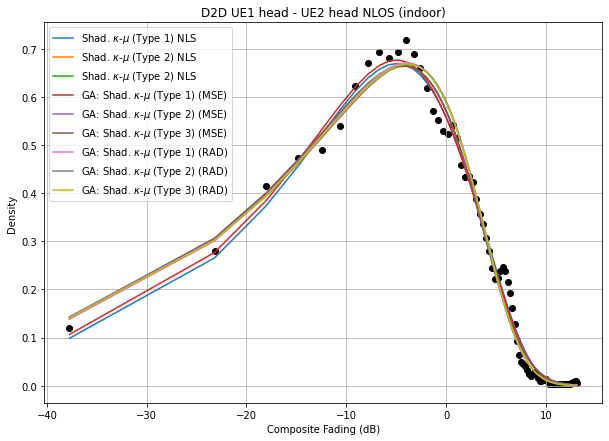

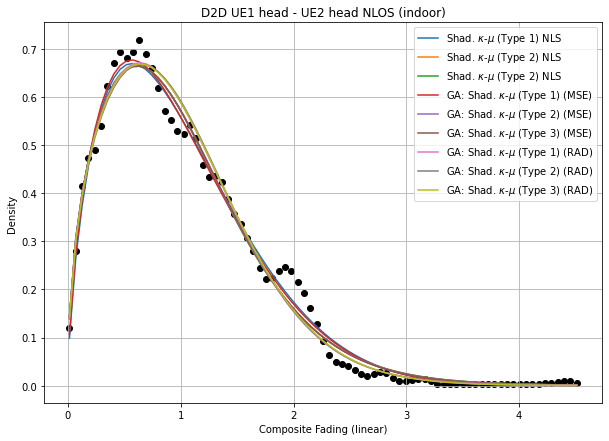

In [246]:
nls_sku_t1_case2_pdf = shadowedKappaMuPDF(Xdata, nls_sku_t1_case2[0], nls_sku_t1_case2[1], nls_sku_t1_case2[2], nls_sku_t1_case2[3]).astype(float)
nls_sku_t2_case2_pdf = shadowedKappaMuPDF_t2(Xdata, nls_sku_t2_case2[0], nls_sku_t2_case2[1], nls_sku_t2_case2[2], nls_sku_t2_case2[3]).astype(float)
nls_sku_t3_case2_pdf = shadowedKappaMuPDF_t3(Xdata, nls_sku_t3_case2[0], nls_sku_t3_case2[1], nls_sku_t3_case2[2], nls_sku_t3_case2[3]).astype(float)

plotResults(Xdata,\
     Ydata,\
     nls_sku_t1_case2_pdf,\
     nls_sku_t2_case2_pdf,\
     nls_sku_t3_case2_pdf,\
     estParameters_sku_t1_t2_t3_case2['GA: Shad. KappaMu T1 - MSE'],\
     estParameters_sku_t1_t2_t3_case2['GA: Shad. KappaMu T1 - RAD'],\
     estParameters_sku_t1_t2_t3_case2['GA: Shad. KappaMu T2 - MSE'],\
     estParameters_sku_t1_t2_t3_case2['GA: Shad. KappaMu T2 - RAD'],\
     estParameters_sku_t1_t2_t3_case2['GA: Shad. KappaMu T3 - MSE'],\
     estParameters_sku_t1_t2_t3_case2['GA: Shad. KappaMu T3 - RAD'],\
     case)

#### AIC Values

In [247]:
## AIC Analysis
data = UE1head_UE2head_NLOS_indoor.dropna()
n = len(data)
K = 4

print('Case: {}'.format(case))

AIC_case2 = computeAIC(data,\
                       n,\
                       K,\
                       nls_sku_t1_case2,\
                       nls_sku_t2_case2,\
                       nls_sku_t3_case2,\
                       estParameters_sku_t1_t2_t3_case2['GA: Shad. KappaMu T1 - MSE'],\
                       estParameters_sku_t1_t2_t3_case2['GA: Shad. KappaMu T1 - RAD'],\
                       estParameters_sku_t1_t2_t3_case2['GA: Shad. KappaMu T2 - MSE'],\
                       estParameters_sku_t1_t2_t3_case2['GA: Shad. KappaMu T2 - RAD'],\
                       estParameters_sku_t1_t2_t3_case2['GA: Shad. KappaMu T3 - MSE'],\
                       estParameters_sku_t1_t2_t3_case2['GA: Shad. KappaMu T3 - RAD'])

Case: D2D UE1 head - UE2 head NLOS (indoor)


,Methods,Akaike Information Criteria
0,GA - Shad. KappaMu T1 (Fitness = RAD),16310.915634
1,GA - Shad. KappaMu T2 (Fitness = RAD),16332.026222
2,GA - Shad. KappaMu T3 (Fitness = RAD),16339.713046
3,GA - Shad. KappaMu T3 (Fitness = MSE),16340.472886
4,GA - Shad. KappaMu T2 (Fitness = MSE),16343.597211
5,NLS - Shad. KappaMu T2,16348.142149
6,NLS - Shad. KappaMu T3,16348.169260
7,GA - Shad. KappaMu T1 (Fitness = MSE),16362.591398
8,NLS - Shad. KappaMu T1,16369.170697


In [ ]:
Case: D2D UE1 head - UE2 head NLOS (indoor)
Methods	Akaike Information Criteria
0	GA - Shad. KappaMu T1 (Fitness = RAD)	16311.836981
1	GA - Shad. KappaMu T3 (Fitness = RAD)	16334.052707
2	GA - Shad. KappaMu T2 (Fitness = RAD)	16337.171989
3	GA - Shad. KappaMu T2 (Fitness = MSE)	16337.252003
4	GA - Shad. KappaMu T3 (Fitness = MSE)	16339.452399
5	NLS - Shad. KappaMu T2	16348.142149
6	NLS - Shad. KappaMu T3	16348.169260
7	GA - Shad. KappaMu T1 (Fitness = MSE)	16363.226749
8	NLS - Shad. KappaMu T1	16369.170697

### D2D UE1 head - UE2 head NLOS (outdoor) [Case 3]

In [ ]:
case = 'D2D UE1 head - UE2 head NLOS (outdoor)'
estParameters_sku_t1_t2_t3_case2 = pd.DataFrame()
Xdata, Ydata = getDensityEstimationSamples(UE1head_UE2head_NLOS_outdoor.dropna(), nExtractedSamples, case)